<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импортируем-библиотеки" data-toc-modified-id="Импортируем-библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем библиотеки</a></span><ul class="toc-item"><li><span><a href="#Загружаем-данные" data-toc-modified-id="Загружаем-данные-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Загружаем данные</a></span></li><li><span><a href="#Изучаем-общую-информацию" data-toc-modified-id="Изучаем-общую-информацию-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Изучаем общую информацию</a></span></li><li><span><a href="#Проверка-на-наличие-дубликатов" data-toc-modified-id="Проверка-на-наличие-дубликатов-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Проверка на наличие дубликатов</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#CustomTokenizer" data-toc-modified-id="CustomTokenizer-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>CustomTokenizer</a></span></li><li><span><a href="#Облако-слов-и-частотность-слов" data-toc-modified-id="Облако-слов-и-частотность-слов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Облако слов и частотность слов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разбиение-выборки-для-TF-IDF-и-бейзлайнов" data-toc-modified-id="Разбиение-выборки-для-TF-IDF-и-бейзлайнов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбиение выборки для TF-IDF и бейзлайнов</a></span></li><li><span><a href="#Baseline-1" data-toc-modified-id="Baseline-1-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Baseline 1</a></span></li><li><span><a href="#Baseline-2" data-toc-modified-id="Baseline-2-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Baseline 2</a></span></li><li><span><a href="#Обучение-на-TF-IDF" data-toc-modified-id="Обучение-на-TF-IDF-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение на TF-IDF</a></span></li><li><span><a href="#Обучение-на-эмбеддингах" data-toc-modified-id="Обучение-на-эмбеддингах-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Обучение на эмбеддингах</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT и TF-IDF

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
___
Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers as ppb
import nltk
import re
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from tqdm import notebook
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from pymorphy2 import MorphAnalyzer

#### Загружаем данные

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

#### Изучаем общую информацию

In [3]:
data.shape

(159571, 2)

У нас 159571 комментарий
___

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Все данные размечены, пропусков нет.

___
Посмотрим распределение классов

In [5]:
data.toxic.value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Токсичны лишь чуть более 10 процентов комментариев. Нужно будет учесть дисбаланс при разбиении выборки на тренировочную и тестовую, а также при построении эмбеддингов при использовании BERT

___
Посмотрим на случайные объекты

In [6]:
data.sample(5, random_state=22)

,text,toxic
157707,"""== UNSC Forces ==\n\nIt says that the UNSC fo...",0
158397,How are you going to handle notable alumni lik...,0
31104,We can use Searchlight for their version. Yes ...,0
13322,as embodied by the IPCC report. This is a per...,0
106754,"Ok \n\nYou nanny hole,suck a fart",1


In [7]:
for comment in data.text.sample(5, random_state=22):
    print(100 * '_' + '\n' + comment)

____________________________________________________________________________________________________
"== UNSC Forces ==

It says that the UNSC forces are on the Rebels' side helping, but I see no mentions of it elsewhere. Although the UNSC forces are helping the Rebels' in the entire war, I'm not so sure that their helping them in this specific battle. Are they helping them in this battle? ARKJEDI10  "
____________________________________________________________________________________________________
How are you going to handle notable alumni like Duffield who attended two different Cornell programs and received two different degrees?
____________________________________________________________________________________________________
We can use Searchlight for their version. Yes we can have only one view, if thats the only view expressed. Do you have UAF's view? Balance and NPOV do nbot require us to put both views, but all expressed significant views. Yet again material is being exci

Нам как минимум потребуется очистить данные от спецсимволов и привести их к нижнему регистру, знаки препинания нужно заменить пробелами (иногда из пишут слитно со словами с каждой стороны).

#### Проверка на наличие дубликатов

In [8]:
data.duplicated().sum()

0

Дубликатов нет

### Предобработка данных

Создадим словарь для обработки сокращенных слов и смайликов

In [9]:
PREPARE_DICT = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"d\'aww": "cute",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great",
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad",
"\"" : " ",
"``": " "
}

In [10]:
# формируем список из стоп-слов и пунктуации
NOISE = stopwords.words('english') + list(punctuation)

### CustomTokenizer

Создадим класс предобработки данных (передадим его в качестве токенизатора в TfIdfVectorizer)

In [181]:
class CustomTokenizer:
    """
    Обрабатывает передаваемый документ: 
    1. Приводит все слова к нижнему регистру
    2. Обрабатывает короткие слова (I've = I have и т.д.) и убираем числа
    3. Удаляет пунктуацию и стоп-слова
    4. Токенизирует
    5. Лемматизирует
    """
    
    def __init__(self, lemmatize=True):
        self.lemmatize=lemmatize
        if lemmatize:
            self.lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    
    def __call__(self, doc):
        # приводим текст к нижнему регистру и обрабатываем сокращенные слова
        doc = self.clear_doc(doc)
        
        if self.lemmatize:
            # токенизируем и лемматизируем текст
            tokens = [self.lemmatizer.lemmatize(word) for word in nltk.word_tokenize(doc) if word not in NOISE]
        else:
            tokens = [word for word in nltk.word_tokenize(doc) if word not in NOISE]
        
        return tokens
    
    def clear_doc(self, doc):
        doc = ' '.join([re.sub(r'[^a-z ]', ' ', PREPARE_DICT.get(word, word)) for word in doc.lower().split()])
        return doc
    
    def clear_doc_for_BERT(self, x):
        # приводим все к lower_case
        x = x.lower() 
        # убираем unicode символы
        x = x.encode('ascii', 'ignore').decode()
        # заменяем сокращения
        x = ' '.join([PREPARE_DICT.get(word, word) for word in x.split()])
        
        # чистим текст
        # убираем все слова с цифрами
        x = re.sub(r'\w*\d+\w*', '', x)
        # убираем все числа со знаками препинания цифрами
        x = re.sub(r'\d*[#-@]\d+', '', x)
        # убираем все отдельные слова не из букв и не из цифр
        x = re.sub(r'\s[^\w\s]\s', ' ', x)
        # убираем двойные пробелы
        x = re.sub(r'\s{2,}', ' ', x)
        return x
    
    def clear_text(self, data):
        """
        Простая очистка текста для BERT-модели
        """
        data['clear_text'] = data['text'].apply(lambda x: self.clear_doc_for_BERT(x))
        return data

Проверим его работу

In [182]:
tokenizer = CustomTokenizer()

In [13]:
tokenizer(r'Hello, world! Today is a beatiful day 2.12.85-06 a15 '' @642 *joe :)')

['hello', 'world', 'today', 'beatiful', 'day', 'joe', 'happy']

Все ок

### Облако слов и частотность слов

In [14]:
toxic_comments = data.query('toxic == 1')['text']
toxic_comments_words_list = [word for comment in toxic_comments.apply(tokenizer) for word in comment]

In [15]:
# посмотрим на частотность токсичных слов
toxic_words_freq_dict = Counter(toxic_comments_words_list)
toxic_words_freq_dict = sorted(toxic_words_freq_dict.items(), key=lambda x: -x[1])

In [16]:
# первые 10 токсичных слов
toxic_words_freq_dict[:10]

[('fuck', 10157),
 ('suck', 4696),
 ('wikipedia', 3939),
 ('like', 3937),
 ('shit', 3710),
 ('nigger', 3434),
 ('fucking', 3337),
 ('as', 3166),
 ('go', 3123),
 ('page', 2870)]

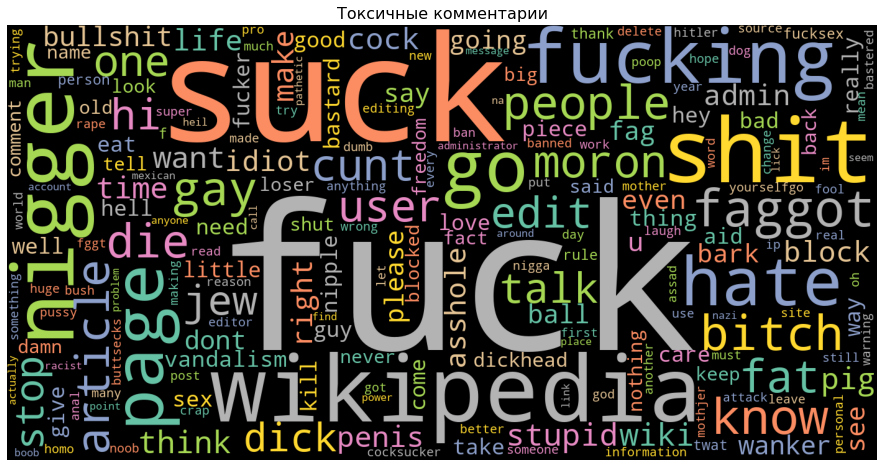

In [17]:
wordcloud_toxic = WordCloud(random_state=22, 
                            width = 1400, 
                            height = 700,
                            background_color='black', 
                            colormap='Set2', 
                            collocations=False, 
                            stopwords = STOPWORDS).generate(' '.join(toxic_comments_words_list))
    
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_toxic) 
plt.axis('off')
plt.title('Токсичные комментарии', fontsize=16);

In [18]:
not_toxic_comments = data.query('toxic == 0')['text']
not_toxic_comments_words_list = [item for sublist in list(not_toxic_comments.apply(tokenizer)) for item in sublist]

In [19]:
# посмотрим на частотность нетоксичных слов
not_toxic_words_freq_dict = Counter(not_toxic_comments_words_list)
not_toxic_words_freq_dict = sorted(not_toxic_words_freq_dict.items(), key=lambda x: -x[1])

In [20]:
not_toxic_words_freq_dict[:10]

[('article', 72416),
 ('page', 54412),
 ('wikipedia', 44686),
 ('talk', 36548),
 ('would', 34392),
 ('one', 28975),
 ('please', 28759),
 ('like', 24499),
 ('source', 21268),
 ('see', 20794)]

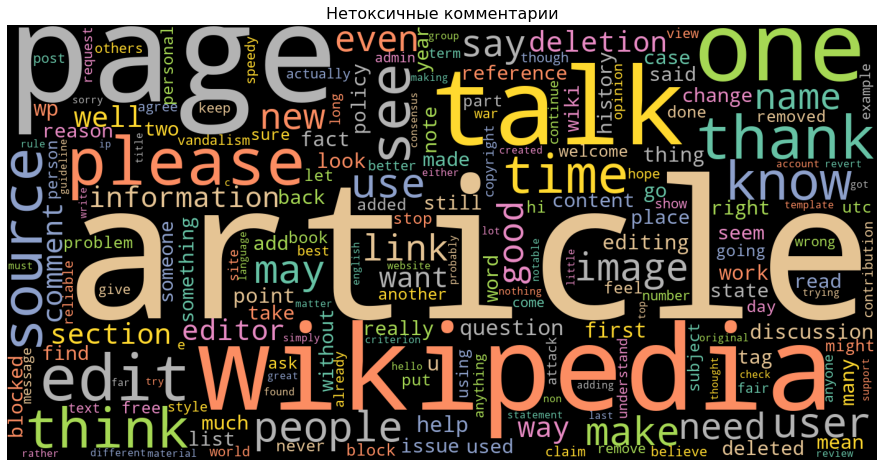

In [21]:
wordcloud_not_toxic = WordCloud(random_state=22, 
                                width = 1400, 
                                height = 700,
                                background_color='black', 
                                colormap='Set2', 
                                collocations=False, 
                                stopwords = STOPWORDS).generate(' '.join(not_toxic_comments_words_list))
    
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_not_toxic) 
plt.axis('off')
plt.title('Нетоксичные комментарии', fontsize=16);

## Обучение

### Разбиение выборки для TF-IDF и бейзлайнов

Разбиваем датасет на тренировочную и тестовую выборки

In [22]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['toxic']), 
                                                    data.toxic, 
                                                    test_size=0.2, 
                                                    random_state=22, 
                                                    stratify=data.toxic)

In [23]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.89832
 1    0.10168
 Name: toxic, dtype: float64,
 0    0.898324
 1    0.101676
 Name: toxic, dtype: float64)

### Baseline 1

Первая базовая модель - простая логистическая регрессия на "сыром" тексте после Tfidf.

In [24]:
# словарь для сохранения результатов работы моделей
result = {}

In [25]:
baseline_vec = TfidfVectorizer(ngram_range=(1, 1))
baseline_bow = baseline_vec.fit_transform(x_train['text'])

In [26]:
clf = LogisticRegression(random_state=22)
clf.fit(baseline_bow, y_train)

LogisticRegression(random_state=22)

In [27]:
baseline_pred = clf.predict(baseline_vec.transform(x_test['text']))
print(classification_report(baseline_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     29780
           1       0.61      0.93      0.74      2135

    accuracy                           0.96     31915
   macro avg       0.80      0.94      0.86     31915
weighted avg       0.97      0.96      0.96     31915



Не такой и плохой результат - всего одной сотой f1-score для первого класса не хватает до необходимого качества.

In [28]:
result['baseline_raw'] = f1_score(baseline_pred, y_test)

### Baseline 2

Вторую базовую модель строим по следующему принципу:
1. Берем x самых часто встречающихся слов в токсичных комментариях.
2. Берем y самых часто встречающихся слов в нетоксичных комментариях.
3. Составляем список с разницей из списков токсичных и нетоксичных комментариев.
4. Если в комментарии присутствует слово из полученного списка, он токсичный, иначе - нетоксичный.

In [29]:
def baseline_predictor(text):
    if len(set(tokenizer(text)).difference(bad_words)) == len(set(tokenizer(text))):
        return 0
    else:
        return 1

Подберем оптимальное количество топ токсичных и нетоксичных слов.

In [30]:
best_f1 = 0
for bad_count in range(200, 300, 20):
    for good_count in range(2000, 3000, 100):
        bad_words = [word for word, count in toxic_words_freq_dict[:bad_count] 
                     if word not in [word for word, count in not_toxic_words_freq_dict[:good_count]]]
        baseline_pred_2 = x_test[:1000]['text'].apply(lambda x: baseline_predictor(x))
        if f1_score(baseline_pred_2, y_test[:1000]) > best_f1:
            best_f1 = f1_score(baseline_pred_2, y_test[:1000])
            best_bad_words = bad_words
            print(f'Best f1: {best_f1}, good count: {good_count}, bad_count: {bad_count}')

Best f1: 0.6037735849056604, good count: 2000, bad_count: 200
Best f1: 0.6233766233766233, good count: 2100, bad_count: 200
Best f1: 0.6357615894039735, good count: 2200, bad_count: 200
Best f1: 0.64, good count: 2300, bad_count: 200


In [31]:
bad_words = best_bad_words
all_baseline_pred = x_test['text'].apply(lambda x: baseline_predictor(x))

In [32]:
print(classification_report(all_baseline_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     29446
           1       0.60      0.78      0.68      2469

    accuracy                           0.94     31915
   macro avg       0.79      0.87      0.82     31915
weighted avg       0.95      0.94      0.95     31915



Для достаточно наивного подхода без какой-либо сложной обработки текста результат достаточно неплох (0.68 для первого класса).

In [33]:
result['baseline_naive'] = f1_score(all_baseline_pred, y_test)

### Обучение на TF-IDF

Сразу обучим лучшие модели с подбором гиперпараметров. 

Рассмотрим логистическую регрессию и бустинг (на основе lightgbm). Работать с дисбалансом классов будем с помощью подбора гиперпараметра 'class_weight' для моделей. 

In [34]:
models_list = [('logreg_on_tfidf', 
                LogisticRegression(random_state=22),
                {'C': [0.2, 0.5, 1], 'class_weight': ['balanced', None]}),
               ('lightgbm_on_tfidf', 
                LGBMClassifier(random_state=22),
                {'max_depth': [-1, 10, 50], 'class_weight': ['balanced', None],
                 'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2, 0.5]})]

In [35]:
vec = TfidfVectorizer(tokenizer=tokenizer)
bow = vec.fit_transform(x_train['text'])

In [36]:
bow_test = vec.transform(x_test['text'])

In [37]:
best_models = []

In [38]:
%%time
for model_name, model, params in models_list:
    print(f'Model {model_name} starts')
    model = RandomizedSearchCV(model, params, scoring='f1', random_state=22)
    model.fit(bow, y_train)
    best_models.append((model_name, model.best_estimator_, model.best_params_, model.best_score_))
    model_predictions = model.best_estimator_.predict(bow_test)
    print(f'Classification report for {model_name}:')
    print(classification_report(model_predictions, y_test))
    print(100 * '_')
    result[model_name] = f1_score(model_predictions, y_test)

Model logreg_on_tfidf starts
Classification report for logreg_on_tfidf:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27768
           1       0.86      0.68      0.76      4147

    accuracy                           0.94     31915
   macro avg       0.91      0.83      0.86     31915
weighted avg       0.94      0.94      0.94     31915

____________________________________________________________________________________________________
Model lightgbm_on_tfidf starts
Classification report for lightgbm_on_tfidf:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     29459
           1       0.68      0.90      0.77      2456

    accuracy                           0.96     31915
   macro avg       0.84      0.93      0.88     31915
weighted avg       0.97      0.96      0.96     31915

_________________________________________________________________________________________________

Результаты обеих моделей оказались немного лучше бейзлайнов. Причем бустинг показал себя немного лучше. 

Посмотрим на результаты подробнее.

In [39]:
best_models

[('logreg_on_tfidf',
  LogisticRegression(C=1, class_weight='balanced', random_state=22),
  {'class_weight': 'balanced', 'C': 1},
  0.7539778511484381),
 ('lightgbm_on_tfidf',
  LGBMClassifier(learning_rate=0.2, max_depth=50, random_state=22),
  {'n_estimators': 100,
   'max_depth': 50,
   'learning_rate': 0.2,
   'class_weight': None},
  0.7686939818721169)]

Логистическая регрессия обучилась лучше с установленной балансировкой классов, а бустинг без.

### Обучение на эмбеддингах

Для построения эмбеддингов используем DistilBert, как более "лёгкую" версию BERT.

In [40]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, 
                                                    ppb.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')

In [41]:
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


С учетом необходимости больших вычислительных мощностей при обучении, сформируем сокращенную выборку для формирования эмбеддингов и построения моделей. При формировании выборки будем следовать следующим принципам:
1. Отберем 10000 объектов для тренировочной выборки и 2000 для тестовой.
2. Для тренировочной выборки отберем объекты так, чтобы сбалансировать классы (5000 объектов каждого класса).
3. Для тестовой выборки отберем объекты с сохранением изначального распределения классов.

In [183]:
toxic_batch = data.query('toxic == 1').sample(5_000, random_state=22)

In [184]:
toxic_indexes = toxic_batch.index.to_list()

In [185]:
not_toxic_batch = data.query('toxic == 0').sample(5_000, random_state=22)

In [186]:
not_toxic_indexes = not_toxic_batch.index.to_list()

In [187]:
all_train_indexes = toxic_indexes + not_toxic_indexes

Убедимся, что дисбаланса для тренировочной выборки не будет.

In [188]:
pd.concat([toxic_batch, not_toxic_batch])['toxic'].value_counts()

1    5000
0    5000
Name: toxic, dtype: int64

Все корректно. Подготовим тестовую выборку. Вспомним исходное рапсределение.

In [189]:
data['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Нам нужно 1796 нетоксичных комментариев и 204 токсичных.

In [190]:
toxic_for_test = data.query('@data.index not in @all_train_indexes & toxic == 1').sample(204, random_state=22)
not_toxic_for_test = data.query('@data.index not in @all_train_indexes & toxic == 0').sample(1796, random_state=22)
test_batch = pd.concat([toxic_for_test, not_toxic_for_test])

Проверим, что в тестовой выборке распределение соответствует изначальному.

In [191]:
test_batch['toxic'].value_counts(normalize=True), data['toxic'].value_counts(normalize=True)

(0    0.898
 1    0.102
 Name: toxic, dtype: float64,
 0    0.898321
 1    0.101679
 Name: toxic, dtype: float64)

Тестовая выборка создана корректно.

Объединим все выборки

In [192]:
bert_batch = pd.concat([toxic_batch, not_toxic_batch, test_batch], ignore_index=True)

Убедимся, что дубликатов нет.

In [193]:
bert_batch.duplicated().sum()

0

Очистим текст для BERT. Как показано в статье https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a, лучше всего модель работает на тексте с небольшой обработкой. Такая очистка реализована в методе clear_text класса CustomTokenizer (п. 1.3 проекта).

In [194]:
bert_batch = tokenizer.clear_text(bert_batch)

In [195]:
bert_batch.sample(3, random_state=22)

,text,toxic,clear_text
3985,u guys are dushbags!!!!!,1,you guys are dushbags!!!!!
2071,"yo nigga, why you reverting my edits? just use...",1,"yo nigga, why you reverting my edits? just use..."
5349,"""Welcome!\n\nHello , and welcome to Wikipedia!...",0,"""welcome! hello and welcome to wikipedia! than..."


Обработка проведена.

In [196]:
tokenized = bert_batch['clear_text'].apply((lambda x: bert_tokenizer.encode(x, 
                                                                            add_special_tokens=True, 
                                                                            truncation=True,
                                                                            max_length=512)))

max_len = tokenized.str.len().max()

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [197]:
%%time

batch_size = 200
embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            model.to(device) # модель тоже
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: total: 3h 25min 26s
Wall time: 35min 41s


In [198]:
features = np.concatenate(embeddings)
features_all = pd.DataFrame(features)
features_all = features_all.join(bert_batch['toxic'])

In [199]:
(X_train_bert, 
 X_test_bert, 
 y_train_bert, 
 y_test_bert) = (features_all[:-2000].drop(columns=['toxic']),
                 features_all[-2000:].drop(columns=['toxic']),
                 features_all[:-2000]['toxic'],
                 features_all[-2000:]['toxic'])

Построим лучшие модели на эмбеддингах

In [203]:
models_list_bert = [('logreg_on_embeddings', 
                    LogisticRegression(random_state=22),
                    {'C': [0.2, 0.5, 1], 'class_weight': ['balanced', None]}),
                    ('lightgbm_on_embeddings', 
                    LGBMClassifier(random_state=22),
                    {'max_depth': [-1, 10, 50], 'class_weight': ['balanced', None],
                     'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2, 0.5]})]

In [204]:
%%time
for model_name, model, params in models_list_bert:
    print(f'Model {model_name} starts')
    model = RandomizedSearchCV(model, params, scoring='f1', random_state=22)
    model.fit(X_train_bert, y_train_bert)
    best_models.append((model_name, model.best_estimator_, model.best_params_, model.best_score_))
    model_predictions = model.best_estimator_.predict(X_test_bert)
    print(f'Classification report for {model_name}:')
    print(classification_report(model_predictions, y_test_bert))
    print(100 * '_')
    result[model_name] = f1_score(model_predictions, y_test_bert)

Model logreg_on_embeddings starts
Classification report for logreg_on_embeddings:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1659
           1       0.89      0.53      0.67       341

    accuracy                           0.91      2000
   macro avg       0.90      0.76      0.81      2000
weighted avg       0.91      0.91      0.90      2000

____________________________________________________________________________________________________
Model lightgbm_on_embeddings starts
Classification report for lightgbm_on_embeddings:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1642
           1       0.88      0.50      0.64       358

    accuracy                           0.90      2000
   macro avg       0.89      0.74      0.79      2000
weighted avg       0.90      0.90      0.89      2000

_____________________________________________________________________________

Модели на эмбеддингах показали результаты хуже, чем на Tfidf, и даже хуже базовых моделей.

## Выводы

В ходе выполнения проекта были выполнены следующие задачи:
1. Проанализированы комментарии.
2. Подготовлен класс-обработчик данных, который очищает, токенизирует и лемматизирует данные.
3. Разработаны две базовых модели.
4. Построены модели на TfidfVectorizer и эмбеддингах. Для моделей проведен подбор гиперпараметров.

Лучший результат показала модель бустинга на TfidfVectorizer, она смогла достичь требуего уровня метрики f1 (0.772). Именно ее можно считать основной.

Модели на эмбеддингах показали результат хуже, чем у базовых моделей. Возможно, это связано с малым числом объектов для обучения или недостаточной обработкой комментариев.

Результаты работы всех моделей приведены в таблице ниже.

In [206]:
result

{'baseline_raw': 0.7353159851301114,
 'baseline_naive': 0.6779838991949597,
 'logreg_on_tfidf': 0.7575757575757575,
 'lightgbm_on_tfidf': 0.772846868970356,
 'logreg_on_embeddings': 0.6678899082568808,
 'lightgbm_on_embeddings': 0.6370106761565836}

In [215]:
pd.DataFrame(result, index=['f1_score']).T.sort_values('f1_score', ascending=False)

,f1_score
lightgbm_on_tfidf,0.772847
logreg_on_tfidf,0.757576
baseline_raw,0.735316
baseline_naive,0.677984
logreg_on_embeddings,0.667890
lightgbm_on_embeddings,0.637011
